In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cooler
import cooltools
save_folder = '../paper_figures'

In [2]:
def collect_bins(M,C,ubins,do_diagonal=False):
    lubins = len(set(ubins))
    MC = np.zeros((lubins,lubins))
    CC = np.zeros((lubins,lubins))
    for ri, row in enumerate(ubins):
        for ci, col in enumerate(ubins):
            if (do_diagonal == False) and (row==col):
                continue
            if np.isnan(M[ri,ci]) or np.isnan(C[ri,ci]):
                continue
            MC[row,col] += M[ri,ci]
            MC[col,row] += M[ci,ri]
            CC[row,col] += C[ri,ci]
            CC[col,row] += C[ci,ri]
    return MC, CC

## Get experimental plasmid copy numbers and plasmid lengths

In [3]:
# plasmid copy numbers
df_copynum = pd.read_excel('Borrelia_plasmid_copy_numbers.xlsx')

# plasmid lengths and ordering
folder = '../data/'

# get example file, and sort plasmid names alphabetically
f = 'BbS9_DpnII_rep4.BbS9.mapq_30.1000.mcool'
resolution = 5000
c = cooler.Cooler(folder +f+f'::/resolutions/{resolution}')
plasmid_names = sorted(c.chromnames[1:])

# obtain the number of bins per plasmid (i.e. plasmid lengths)
num_bins_per_plasmid = np.round(c.chromsizes//resolution) 
num_bins_per_plasmid_dict = num_bins_per_plasmid[1:] 
num_bins_per_plasmid_dict

name
cp26       5
cp32-1     6
cp32-3     6
cp32-4     6
cp32-6     5
cp32-7     6
cp32-8     6
cp32-9     6
lp17       3
lp21       3
lp25       4
lp28-1     5
lp28-2     5
lp28-3     5
lp28-4     5
lp36       7
lp38       7
lp54      10
Name: length, dtype: int32

In [4]:
# sort the plasmid copy number DataFrame according to plasmid name
df_copynum.sort_values('replicon or loci',inplace=True,ignore_index=True)
df_copynum

,replicon or loci,WGS_Borrelia_S9_rep1,WGS_Borrelia_S9_rep1_redo,WGS_Borrelia_S9_rep2,WGS_Borrelia_S9_rep2_redo,S9 average
0,cp26_copy,1.42,1.22,1.37,1.24,1.31
1,cp32_1_copy,0.50,0.55,0.59,0.60,0.56
2,cp32_3_copy,0.47,0.50,0.55,0.56,0.52
3,cp32_4_copy,0.52,0.56,0.60,0.62,0.58
4,cp32_6_copy,0.51,0.55,0.59,0.60,0.56
5,cp32_7_copy,0.47,0.50,0.55,0.55,0.52
6,cp32_8_copy,0.54,0.58,0.63,0.63,0.60
7,cp32_9_copy,0.42,0.46,0.48,0.49,0.46
8,lp17_copy,1.45,1.05,1.55,1.20,1.31
9,lp21_copy,1.01,0.92,1.30,0.68,0.98


## Generate theoretical probability curve (copy number and length)

In [5]:
# get number of bins accounting for plasmid copy number and length
num_bins_per_plasmid = []
for p, L in num_bins_per_plasmid_dict.items():
    pp = "_".join(p.split('-'))+'_copy'
    n = df_copynum[df_copynum['replicon or loci'] == pp]['S9 average'].values[0]
    num_bins_per_plasmid.append(np.round(n*L))


In [6]:
# generate expected plasmid-plasmid interactions map accounting for length and copy number
sum_tot = np.sum(num_bins_per_plasmid)
M = np.zeros((len(num_bins_per_plasmid), len(num_bins_per_plasmid)))
for i, pi in enumerate(num_bins_per_plasmid):
    for j, pj in enumerate(num_bins_per_plasmid):
        M[i,j] = pi*pj/sum_tot**2
        if i==j:
            M[i,j] = 0
res = cooltools.numutils.iterative_correction_symmetric(M,ignore_diags=0)


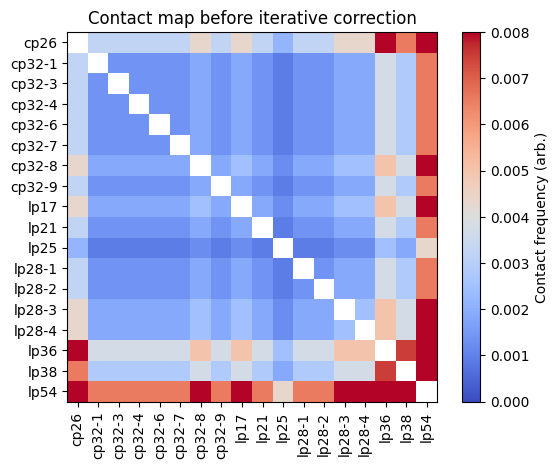

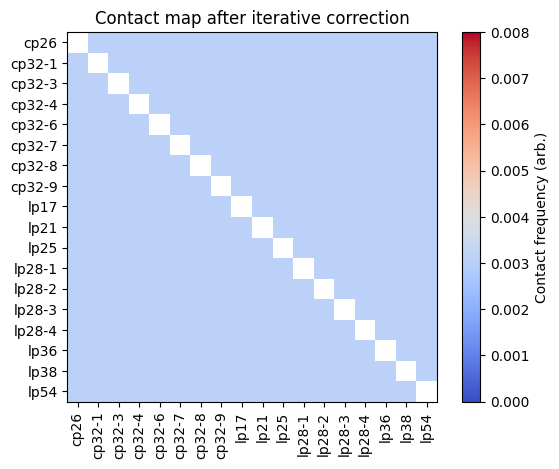

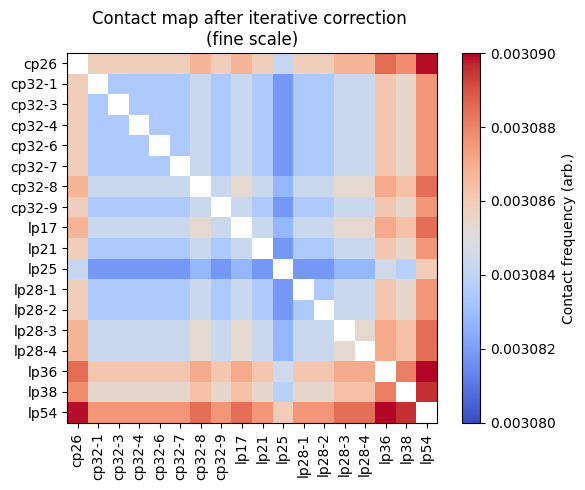

In [8]:
# plot results without iterative correction
M[M==0] = np.nan # remove the main diagonal ("self" interactions)
plt.imshow(M,cmap='coolwarm',vmax=0.008,vmin=0);
plt.title('Contact map before iterative correction')
plt.yticks(np.arange(0,len(plasmid_names)),labels=plasmid_names)
plt.xticks(np.arange(0,len(plasmid_names)),labels=plasmid_names,rotation='vertical')
plt.colorbar(label='Contact frequency (arb.)')
plt.savefig(os.path.join(save_folder, f'Theoretical_plasmid_interaction_frequency_for_lengthAndNumber_noIC.pdf'),bbox_inches='tight')
plt.show()

# plot results with iterative correction
res[0][res[0]==0] = np.nan
plt.imshow(res[0],cmap='coolwarm',vmax=0.008,vmin=0.)
plt.yticks(np.arange(0,len(plasmid_names)),labels=plasmid_names)
plt.xticks(np.arange(0,len(plasmid_names)),labels=plasmid_names,rotation='vertical')
plt.colorbar(label='Contact frequency (arb.)')
plt.title('Contact map after iterative correction')
plt.savefig(os.path.join(save_folder, f'Theoretical_plasmid_interaction_frequency_for_lengthAndNumber_withIC.pdf'),bbox_inches='tight')
plt.show()

# plot results with iterative correction and very fine colorbar scale
plt.imshow(res[0],cmap='coolwarm',vmax=0.00309,vmin=0.00308)
plt.yticks(np.arange(0,len(plasmid_names)),labels=plasmid_names)
plt.xticks(np.arange(0,len(plasmid_names)),labels=plasmid_names,rotation='vertical')
plt.colorbar(label='Contact frequency (arb.)')
plt.title('Contact map after iterative correction \n(fine scale)')
plt.savefig(os.path.join(save_folder, f'Theoretical_plasmid_interaction_frequency_for_lengthAndNumber_withIC_superfinescale.pdf'),bbox_inches='tight')
plt.show()

## Generate theoretical probability curve (copy number only)

In [9]:
# get number of bins accounting for plasmid copy number only
num_bins_per_plasmid = []
for p, L in num_bins_per_plasmid_dict.items():
    pp = "_".join(p.split('-'))+'_copy'
    n = df_copynum[df_copynum['replicon or loci'] == pp]['S9 average'].values[0]
    num_bins_per_plasmid.append(np.round(n*10))  
    
    
# Compute probabilities associated with plasmid-plasmid interaction
sum_tot = np.sum(num_bins_per_plasmid)
M = np.zeros((len(num_bins_per_plasmid), len(num_bins_per_plasmid)))
for i, pi in enumerate(num_bins_per_plasmid):
    for j, pj in enumerate(num_bins_per_plasmid):
        M[i,j] = pi*pj/sum_tot**2
        if i==j:
            M[i,j] = 0

# Perform iterative correction
res= cooltools.numutils.iterative_correction_symmetric(M,ignore_diags=0)

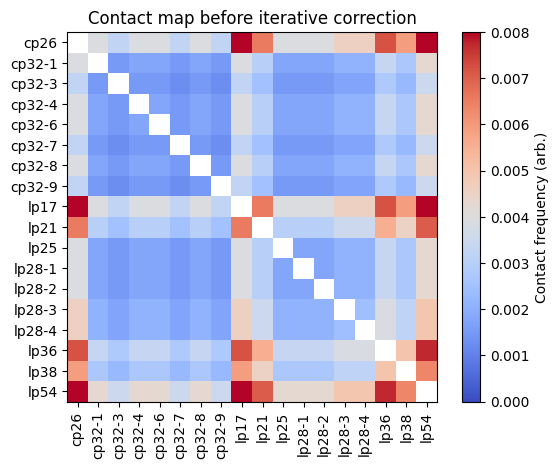

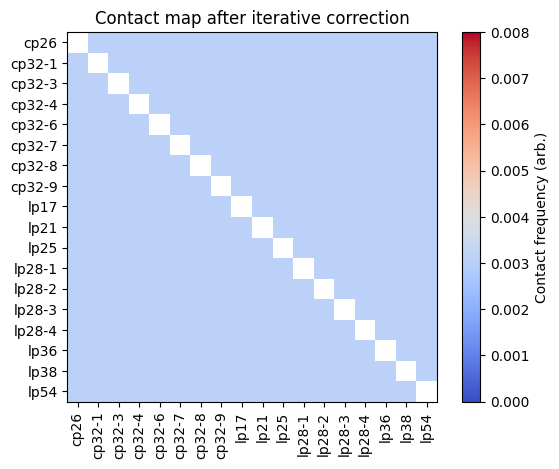

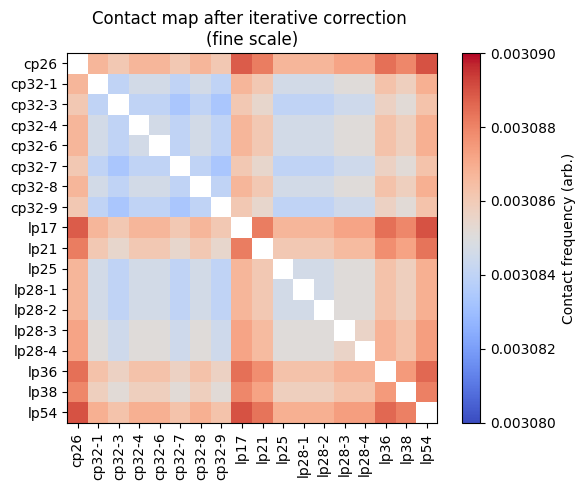

In [10]:
# plot results without iterative correction
M[M==0] = np.nan    
plt.imshow(M,cmap='coolwarm',vmax=0.008,vmin=0);
plt.title('Contact map before iterative correction')
plt.yticks(np.arange(0,len(plasmid_names)),labels=plasmid_names)
plt.xticks(np.arange(0,len(plasmid_names)),labels=plasmid_names,rotation='vertical')
plt.colorbar(label='Contact frequency (arb.)')
plt.savefig(os.path.join(save_folder, f'Theoretical_plasmid_interaction_frequency_for_numberOnly_noIC.pdf'),bbox_inches='tight')
plt.show()

# plot results with iterative correction
res[0][res[0]==0]=np.nan
plt.imshow(res[0],cmap='coolwarm',vmax=0.008,vmin=0.)
plt.yticks(np.arange(0,len(plasmid_names)),labels=plasmid_names)
plt.xticks(np.arange(0,len(plasmid_names)),labels=plasmid_names,rotation='vertical')
plt.colorbar(label='Contact frequency (arb.)')
plt.title('Contact map after iterative correction')
plt.savefig(os.path.join(save_folder, f'Theoretical_plasmid_interaction_frequency_for_numberOnly_withIC.pdf'),bbox_inches='tight')
plt.show()

# plot results with iterative correction and fine colour scale
plt.imshow(res[0],cmap='coolwarm',vmax=0.00309,vmin=0.00308)
plt.yticks(np.arange(0,len(plasmid_names)),labels=plasmid_names)
plt.xticks(np.arange(0,len(plasmid_names)),labels=plasmid_names,rotation='vertical')
plt.colorbar(label='Contact frequency (arb.)')
plt.title('Contact map after iterative correction \n(fine scale)')
plt.savefig(os.path.join(save_folder, f'Theoretical_plasmid_interaction_frequency_for_numberOnly_withIC_superfinescale.pdf'),bbox_inches='tight')
plt.show()